# Compréhension du problème :
On travaille sur un problème de régression, car on essaye de prédire une valeur numérique continue 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions' à partir de caractéristiques de bâtiments.

# Les modèles testés seront les suivants : 

## Linear Regression (Régression linéaire):
La régression linéaire est un modèle de régression simple qui tente de modéliser la relation linéaire entre les caractéristiques (variables prédictives) et la variable cible.
L'objectif est de trouver une ligne droite (ou un hyperplan en plusieurs dimensions) qui minimise l'erreur quadratique moyenne entre les prédictions du modèle et les valeurs réelles de la variable cible.
C'est un modèle simple et facile à interpréter, mais il suppose que la relation entre les caractéristiques et la cible est linéaire, ce qui peut ne pas être vrai dans tous les cas.

## ElasticNet:
ElasticNet est une extension de la régression linéaire qui combine à la fois la régression L1 (Lasso) et la régression L2 (Ridge).
Il est utilisé pour gérer le problème de la multicollinéarité (lorsque les caractéristiques sont fortement corrélées) et pour effectuer la sélection automatique des caractéristiques en réduisant les coefficients de certaines caractéristiques à zéro.
Les paramètres alpha et l1_ratio permettent de contrôler le mélange entre L1 et L2.

## Random Forest Regressor (Régresseur à forêts aléatoires):
Les forêts aléatoires sont des modèles d'ensemble basés sur des arbres de décision.
Dans le cas du régresseur à forêts aléatoires, de nombreux arbres de décision sont construits lors de l'apprentissage et les prédictions finales sont la moyenne des prédictions de chaque arbre.
Ils sont très flexibles et peuvent modéliser des relations complexes entre les caractéristiques et la variable cible. Ils sont également robustes face aux données bruyantes et aux valeurs aberrantes.

## Gradient Boosting Regressor (Régresseur par Gradient Boosting):
Le régresseur par gradient boosting est un autre modèle d'ensemble qui construit un modèle prédictif en ajoutant séquentiellement des arbres de décision faibles.
À chaque étape, le modèle tente de corriger les erreurs du modèle précédent en ajustant les poids des observations mal prédites.
Cela conduit généralement à un modèle très puissant, capable de modéliser des relations complexes. Cependant, il est plus susceptible de sur-ajuster si les hyperparamètres ne sont pas correctement réglés.

## Support Vector Regressor (Régresseur à vecteurs de support):
Le régresseur à vecteurs de support est utilisé pour la régression. Il est basé sur le même principe que la classification SVM, mais il vise à minimiser les erreurs de prédiction pour les données de régression.
Il tente de trouver un hyperplan (ou une surface hyperplane en plusieurs dimensions) qui maximise la marge entre les points de données et la prédiction du modèle.
Il est efficace pour les données de faible dimension, mais peut être moins approprié pour les ensembles de données de grande dimension.

# GridSearchCV

Le modèle d'apprentissage automatique (comme une régression linéaire) a quelques paramètres ajustables pour qu'il fonctionne mieux. 
Par exemple, pour la régression linéaire, on peut ajuster la valeur de régularisation.

On ne connait pas la meileur valeure régularisation mais on pourrait tester différentes valeurs (comme 0.1, 0.01, 0.001, etc.) et voir laquelle donne les meilleurs résultats. Cela peut prendre beaucoup de temps et d'efforts.

GridSearchCV permet de donner liste de valeurs possibles pour chaque paramètre et va tester toutes les combinaisons possibles de ces valeurs pour les paramètres, en ajustant le modèle et évaluant ses performances sur vos données d'entraînement. Il enregistre les performances pour chaque combinaison.

GridSearchCV nous donne la meilleure combinaison de paramètres qui donne les meilleures performances sur nos données d'entraînement. C'est comme demander à un ordinateur de trouver la meilleure configuration pour notre modèle, au lieu de le faire manuellement.

Cela permet d'optimiser le modèle et d'obtenir de meilleurs résultats sans avoir à essayer chaque combinaison possible nous-même.


# Hyperparamètres 

Aucun hyperparamètre à régler : LinearRegression est un modèle de régression linéaire simple qui ne possède pas d'hyperparamètres spécifiques à régler lors de la recherche par grille. Il s'agit d'un modèle linéaire de base qui ajuste une ligne droite aux données.

### ElasticNet :
* model__alpha : Le paramètre d'ajustement alpha contrôle la régularisation du modèle. Il s'agit d'un coefficient qui pondère la pénalité L1 (lasso) et la pénalité L2 (ridge). Les valeurs plus élevées d'alpha augmentent la régularisation. Nous essayons trois valeurs différentes : 0.01, 0.1 et 1.0.
* model__l1_ratio : Le rapport l1_ratio contrôle le mélange entre la régularisation L1 et L2. Une valeur de 1 signifie une régularisation L1 pure (lasso), 0 signifie une régularisation L2 pure (ridge), et une valeur entre les deux effectue un mélange des deux. Nous essayons trois valeurs différentes : 0.1, 0.5 et 0.9.
* model__max_iter : Le nombre maximum d'itérations pour la convergence de l'algorithme d'optimisation. Nous essayons deux valeurs : 1000 et 2000.

### RandomForestRegressor :
* model__n_estimators : Le nombre d'arbres de décision dans la forêt aléatoire. Plus il y a d'arbres, mieux c'est, mais cela peut augmenter le temps de calcul. Nous essayons trois valeurs différentes : 50, 100 et 200.
* model__max_depth : La profondeur maximale de chaque arbre de décision. Une profondeur plus grande peut conduire à un surajustement. Nous essayons quatre valeurs différentes : None (pas de limite de profondeur), 10, 20 et 30.

### GradientBoostingRegressor :
* model__n_estimators : Le nombre d'itérations pour ajuster les arbres de décision. Plus il y en a, plus le modèle est complexe. Nous essayons trois valeurs différentes : 50, 100 et 200.
* model__max_depth : La profondeur maximale de chaque arbre de décision dans le gradient boosting. Une profondeur plus grande peut conduire à un surajustement. Nous essayons trois valeurs différentes : 3, 4 et 5.

### SVR (Support Vector Regressor) :
* model__C : Le paramètre de régularisation qui contrôle la tolérance aux erreurs d'entraînement. Des valeurs plus élevées de C permettent une meilleure adéquation aux données d'entraînement, mais peuvent entraîner un surajustement. Nous essayons trois valeurs différentes : 0.1, 1 et 10.
* model__kernel : Le noyau utilisé dans le modèle SVR. Nous essayons deux noyaux différents : "linear" (linéaire) et "rbf" (radial basis function).

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# Data

In [2]:
data = pd.read_csv('data_saved.csv')

# Chargement de la liste des targets et features

In [3]:
features = np.load('features.npy')
targets = np.load('targets.npy')

### Création d'une liste de caractéristiques continues et catégorielles pour différencier quelles caractéristiques nécessitent un traitement.

In [4]:
# Initialisation des listes vides pour les caractéristiques continues et catégorielles
features_continuous = []
features_categorical = []

# Boucle à travers les caractéristiques et identification de leur type de données
for feature in features:
    dtype = data[feature].dtype
    if np.issubdtype(dtype, np.number):  # Vérifiez si c'est un type de données numérique
        features_continuous.append(feature)
    else:
        features_categorical.append(feature)

# Affichez les caractéristiques continues et catégorielles
print("Caractéristiques continues :", features_continuous)
print("Caractéristiques catégorielles :", features_categorical)

Caractéristiques continues : ['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'BuildingAge', 'LargestPropertyUseTypeGFA', 'Electricity(kWh)', 'Electricity(kBtu)']
Caractéristiques catégorielles : ['PrimaryPropertyType']


In [5]:
print(targets)

['SiteEnergyUse(kBtu)' 'TotalGHGEmissions']


In [6]:
print("Caractéristiques continues :", features_continuous)
print("Caractéristiques catégorielles :", features_categorical)

Caractéristiques continues : ['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'BuildingAge', 'LargestPropertyUseTypeGFA', 'Electricity(kWh)', 'Electricity(kBtu)']
Caractéristiques catégorielles : ['PrimaryPropertyType']


# Pipeline complet avec le préprocesseur et le modèles d'apprentissages supervisés pour target 'SiteEnergyUse(kBtu)'

In [12]:
# Caractéristiques X et  variable cible y
X = data[features]
y = data['SiteEnergyUse(kBtu)']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des colonnes numériques
numerical_cols = ['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'BuildingAge', 'LargestPropertyUseTypeGFA', 'Electricity(kWh)', 'Electricity(kBtu)']

# Liste des colonnes catégorielles (à encoder en one-hot)
categorical_cols = ['PrimaryPropertyType']

# Créer un préprocesseur pour les caractéristiques numériques
numeric_transformer = StandardScaler()

# Préprocesseur pour les colonnes catégorielles (encodage en one-hot)
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')


# Créer une fonction pour entraîner et évaluer un modèle
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    
    # Créer un pipeline avec le préprocesseur et le modèle
    # Définition du ColumnTransformer
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Entraîne le modèle via le pipeline
    pipeline.fit(X_train, y_train)

    # Fait des prédictions sur les données de test
    y_pred = pipeline.predict(X_test)

    # Évalue la performance du modèle
    mse = mean_squared_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    return mse, r_squared

# Créer une liste d'algorithmes à tester
models_to_test = [
    LinearRegression(),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR()
]

# Boucle à travers les modèles, entraînements et évaluations
for model in models_to_test:
    mse, r_squared = train_evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"Model: {model.__class__.__name__}")
    print("Mean Squared Error:", mse)
    print("R-squared:", r_squared)
    print()

Model: LinearRegression
Mean Squared Error: 39824051282878.71
R-squared: 0.9306960908195081

Model: ElasticNet
Mean Squared Error: 64671708231296.29
R-squared: 0.887454890965954

Model: RandomForestRegressor
Mean Squared Error: 35666525396108.24
R-squared: 0.9379312360945485

Model: GradientBoostingRegressor
Mean Squared Error: 23377481034364.21
R-squared: 0.9593172776178402

Model: SVR
Mean Squared Error: 609532040543933.5
R-squared: -0.0607397243539074



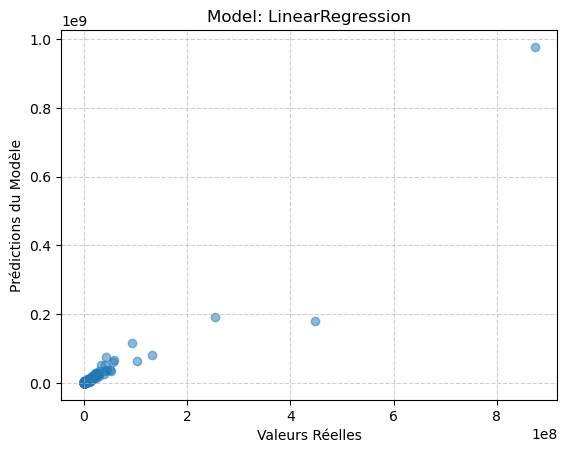

Model: LinearRegression
Best Hyperparameters: {}
Mean Squared Error: 283054674260915.44
R-squared: 0.9111081253726875
Training Time (s): 2.124060869216919



/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 884987528407384.0, tolerance: 42594054329245.48
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85395451469748.0, tolerance: 36200695743062.97
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2945183719018276e+16, tolerance: 34141571934024.61
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklea

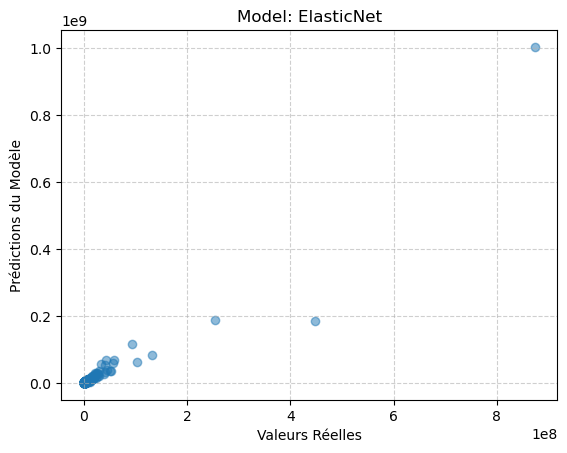

Model: ElasticNet
Best Hyperparameters: {'model__alpha': 0.01, 'model__l1_ratio': 0.9, 'model__max_iter': 2000}
Mean Squared Error: 296928125113630.94
R-squared: 0.9067512389970503
Training Time (s): 1.9361200332641602



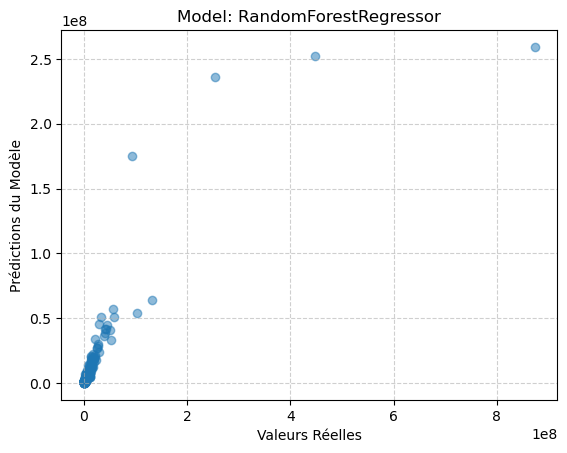

Model: RandomForestRegressor
Best Hyperparameters: {'model__max_depth': 30, 'model__n_estimators': 200}
Mean Squared Error: 1299072157510601.0
R-squared: 0.5920330245074141
Training Time (s): 14.205182075500488



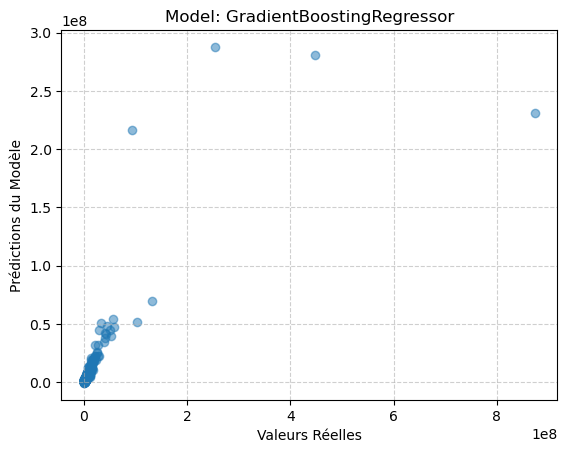

Model: GradientBoostingRegressor
Best Hyperparameters: {'model__max_depth': 4, 'model__n_estimators': 200}
Mean Squared Error: 1400208682792502.2
R-squared: 0.5602716153412339
Training Time (s): 3.0188920497894287



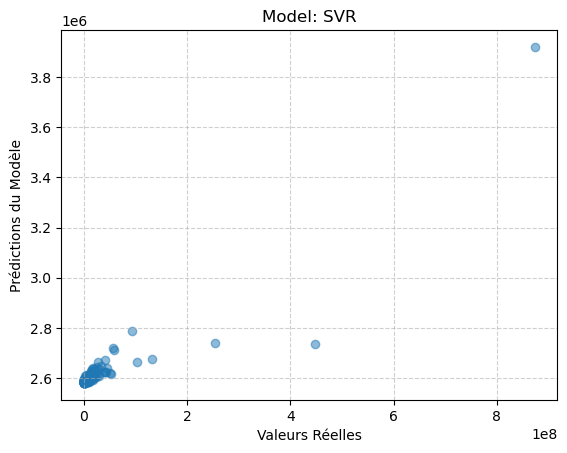

Model: SVR
Best Hyperparameters: {'model__C': 10, 'model__kernel': 'linear'}
Mean Squared Error: 3257102099086668.5
R-squared: -0.022876277158682345
Training Time (s): 0.4290759563446045



In [13]:
# Caractéristiques X et  variable cible y
X = data[features]
y = data['SiteEnergyUse(kBtu)']


# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['PrimaryPropertyType'])

# Liste des colonnes numériques
numerical_cols = ['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'BuildingAge', 'LargestPropertyUseTypeGFA', 'Electricity(kWh)', 'Electricity(kBtu)']

# Liste des colonnes catégorielles (à encoder en one-hot)
categorical_cols = ['PrimaryPropertyType']

# Créer un préprocesseur pour les caractéristiques numériques
numeric_transformer = StandardScaler()

# Préprocesseur pour les colonnes catégorielles (encodage en one-hot)
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')


# Créer une fonction pour entraîner et évaluer un modèle avec GridSearchCV
def train_evaluate_model_with_grid_search(model, param_grid, X_train, y_train, X_test, y_test):
    # Créez un pipeline avec le préprocesseur et le modèle
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    
    
    # Créer l'objet GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Mesure le temps de calcul
    start_time = time.time()
    
    # Entraîne le modèle avec GridSearchCV
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Fait des prédictions sur les données de test
    y_pred = grid_search.predict(X_test)
    
    # Évalue la performance du modèle
    mse = mean_squared_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    # Faites des prédictions sur les données de test
    y_pred = grid_search.predict(X_test)
    
    # Évalue la performance du modèle
    mse = mean_squared_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    
    # Créez un graphique de dispersion pour les prédictions vs valeurs réelles
    plt.figure()
    plt.title(f"Model: {model.__class__.__name__}")
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Valeurs Réelles")
    plt.ylabel("Prédictions du Modèle")
    plt.grid(True, linestyle='--', alpha=0.6)

    # Affichez le graphique
    plt.show()
    
    return mse, r_squared, grid_search.best_params_, training_time

# Créer une liste d'algorithmes à tester
models_to_test = [
    LinearRegression(),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR()
]

# Définis les grilles de recherche pour chaque modèle
param_grids = [
    # Grille de recherche pour LinearRegression (aucun hyperparamètre à régler)
    {},
    
    # Grille de recherche pour ElasticNet
    {
        'model__alpha': [0.01, 0.1, 1.0], 
        'model__l1_ratio': [0.1, 0.5, 0.9],
        'model__max_iter': [1000, 2000]
    },
    
    # Grille de recherche pour RandomForestRegressor
    {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30]
    },
    
    # Grille de recherche pour GradientBoostingRegressor
    {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 4, 5]
    },
    
    # Grille de recherche pour SVR
    {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    }
]

# Boucle à travers les modèles, effectue la recherche par grille et mesurez le temps de calcul
for model, param_grid in zip(models_to_test, param_grids):
    mse, r_squared, best_params, training_time = train_evaluate_model_with_grid_search(model, param_grid, X_train, y_train, X_test, y_test)
    print(f"Model: {model.__class__.__name__}")
    print("Best Hyperparameters:", best_params)
    print("Mean Squared Error:", mse)
    print("R-squared:", r_squared)
    print("Training Time (s):", training_time)
    print()


    